In [1]:
import csv, json, os, shutil
import pandas as pd
import matplotlib.pyplot as plt
from coco.coco import CocoDetection
from os import listdir
import os.path as osp
import numpy as np
from typing import Optional, List, Dict

Utility

In [2]:
def conv2human(df:pd.DataFrame):
    """ include human-like annotation"""
    format_file = 'traffic_genome_format/traffic_genome_format.json'

    with open(format_file, 'r') as f:
        tmp = json.load(f)
        tmp_ent = tmp['idx_to_label']
        
        entity_map = {  str(int(k)-1):v    for k,v in tmp_ent.items()  }
        rel2idx = tmp['predicate_to_idx']
        
        tmp_rel = tmp['idx_to_predicate']
        rel_map = {  str(int(k)-1):v    for k,v in tmp_rel.items()  }
        
    df['sub_name'] = df.apply(lambda r: entity_map[str(r['sub'])], axis=1)
    df['obj_name'] = df.apply(lambda r: entity_map[str(r['obj'])], axis=1)
    df['rel_name'] = df.apply(lambda r: rel_map[str(r['rel'])], axis=1)

    return df, rel_map

def plot_distr_rel(df:pd.DataFrame, title:str):
    """ plot relationship distribution"""
    rel_freq = df.groupby('rel_name').size().reset_index(name='frequency')

    sorted_rel  = rel_freq.sort_values(by='frequency', ascending=False)

    plt.rcParams.update({'font.size': 25})   
    plt.figure(figsize=(50, 20)) 
    # filter background relationship
    plt.bar(sorted_rel['rel_name'], sorted_rel['frequency'])
    plt.xticks(rotation=90)
    plt.title(f'Relationship distribution in {title}')
    plt.savefig('tg_rel_distr.jpg',dpi=300, bbox_inches='tight' )
    plt.show()
    


def plot_distr_entity(df:pd.DataFrame, title:str):
    """ plot relationship distribution"""
    rel_freq = df.groupby('rel_name').size().reset_index(name='frequency')

    sorted_rel  = rel_freq.sort_values(by='frequency', ascending=False)

    plt.rcParams.update({'font.size': 25})   
    plt.figure(figsize=(50, 20)) 
    # filter background relationship
    plt.bar(sorted_rel['rel_name'], sorted_rel['frequency'])
    plt.xticks(rotation=90)
    plt.title(f'Relationship distribution in {title}')
    plt.savefig('tg_rel_distr.jpg',dpi=300, bbox_inches='tight' )
    plt.show()    
    
    
    
def create_df(img_folder:str, ann_path:str, set_name:str)->pd.DataFrame:

    triplet = { 'sub':[], 'obj': [], 'rel': []}

    assert set_name in ['train', 'val', 'test'], 'wrong set name'
    for ann_file in listdir(ann_path):
        a = osp.join(ann_path, ann_file)
        if ann_file.startswith(set_name) and  ann_file !='rel.json':
    
            set = CocoDetection(img_folder, a, transforms=None, return_masks=False)

            # load the relationship for this seet
            for i in range(len(set)):
                _, target = set[i]
                relation_idx = target['rel_annotations'].cpu().numpy()
            
                
                
                triplet['sub'].extend(target['labels'][relation_idx[:, 0]].tolist())
                triplet['obj'].extend(target['labels'][relation_idx[:, 1]].tolist())
                triplet['rel'].extend(relation_idx[:, 2].tolist())
                
                
                
            
    return pd.DataFrame(triplet) 


Upload relationship

In [3]:
img_folder = 'traffic_genome_img'
ann_path = 'coco_traffic_genome_v2/'



triplet = { 'sub':[], 'obj': [], 'rel': []}

for ann_file in listdir(ann_path):
    a = osp.join(ann_path, ann_file)
    if ann_file.endswith('.json') and  ann_file !='rel.json':
   
        set = CocoDetection(img_folder, a, transforms=None, return_masks=False)

        # load the relationship for this seet
        for i in range(len(set)):
            _, target = set[i]
            relation_idx = target['rel_annotations'].cpu().numpy()
        
            
             
            triplet['sub'].extend(target['labels'][relation_idx[:, 0]].tolist())
            triplet['obj'].extend(target['labels'][relation_idx[:, 1]].tolist())
            triplet['rel'].extend(relation_idx[:, 2].tolist())

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


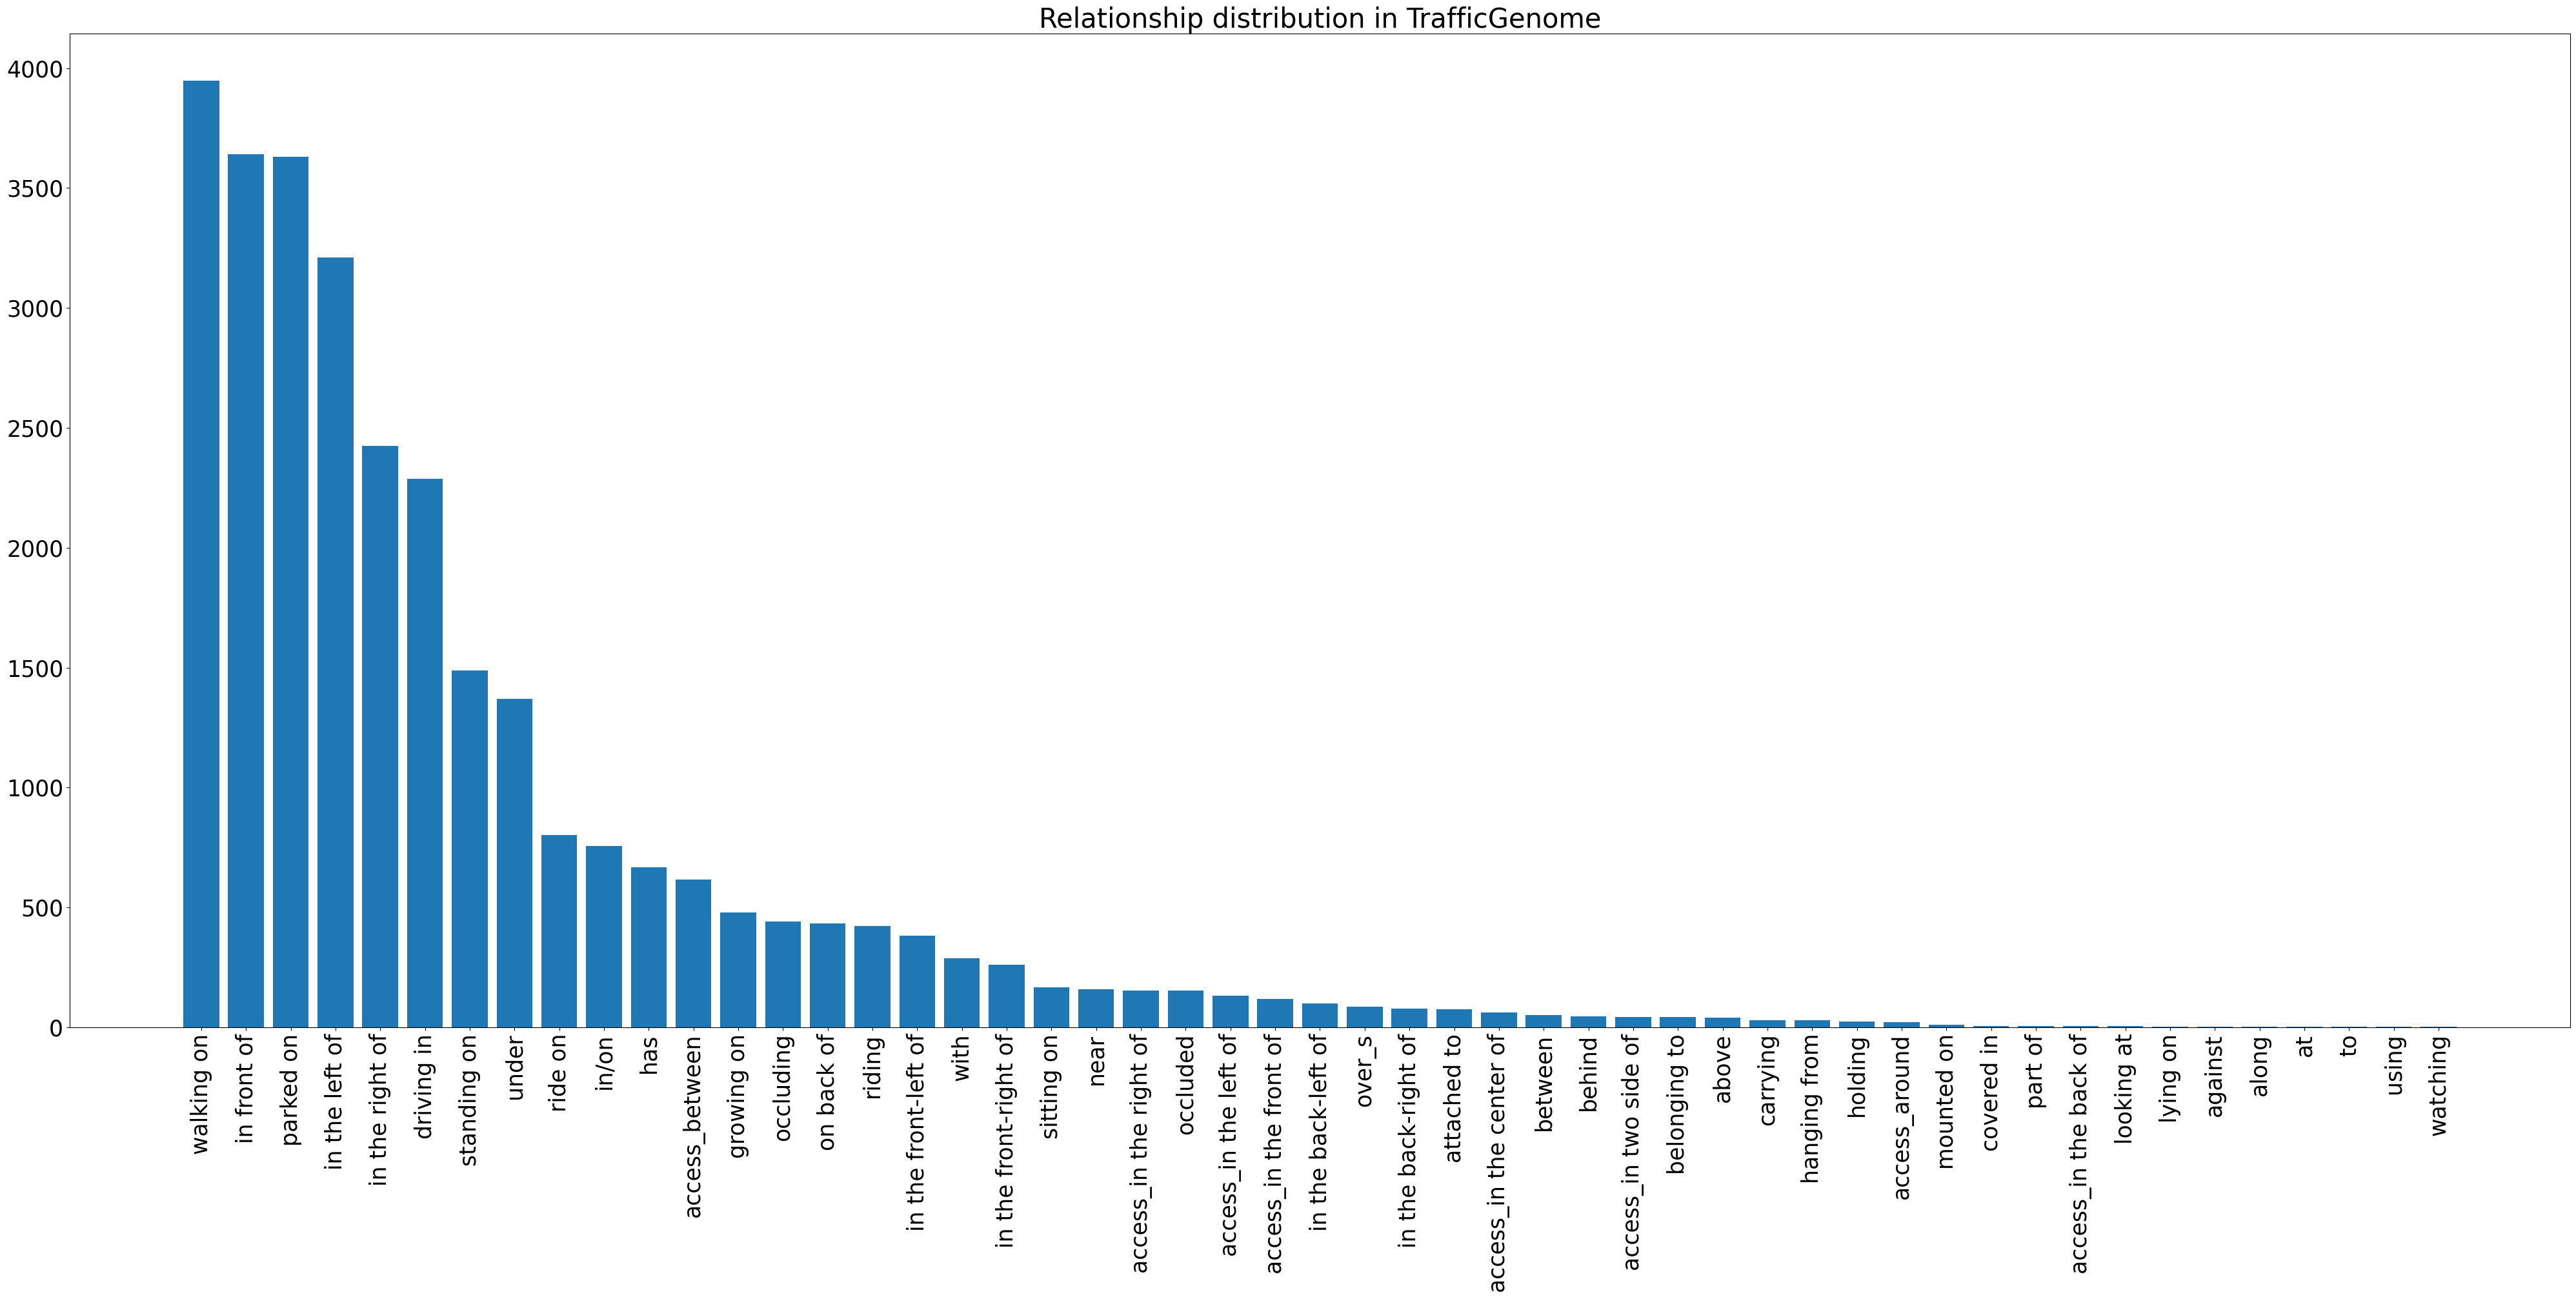

In [4]:
df_tg = pd.DataFrame(triplet)           
df_tg, rel_map = conv2human(df_tg)
plot_distr_rel(df_tg, 'TrafficGenome') 

In [5]:

stats_file = 'tgv2_rel_human_format.csv'

human_df = df_tg[ ['sub_name', 'rel_name', 'obj_name']]
human_df.to_csv(stats_file, header=True) 

In [6]:
try:
    os.makedirs('constraint/tgv2_stats/')
except:
    shutil.rmtree('constraint/tgv2_stats/')
    os.makedirs('constraint/tgv2_stats/')
def save_rel_hit(rel_name:str, df:pd.DataFrame)->None:
    """
    save all relationship hit in a csv file for further statistical analysis, which is used to constraints generation
    """
    
    stats_file = 'constraint/tgv2_stats/' +rel_name.replace(' ', '').replace('/','_').replace('-', '_') + '_stats.csv'
    
    df_tg[ df_tg['rel_name']== rel_name].to_csv(stats_file, header=True, index=False)  

In [7]:
for v in rel_map.values():
    save_rel_hit(v, human_df)

check

In [8]:
group_df = df_tg.drop_duplicates().groupby('rel_name')[['sub', 'rel', 'obj']]

# dd = group_df.apply(lambda row: row['sub_name'] )
rel_i = 'near'
group_df.get_group(rel_i)
# TODO: group by sub and obj to create a list of constraints

,sub,rel,obj
280,22,17,8
508,13,17,12
543,12,17,11
1674,26,17,11
1675,24,17,11
1698,24,17,24
1758,12,17,7
1763,26,17,8
1796,27,17,8
1813,26,17,19


In [13]:
def gen_pos_constr(rel_names:List[str], df: pd.DataFrame, constr_filename:str):
    """ generate the positive constraints into a csv file given the relationship in rel_names"""
    
    first = True
    group_df = df.drop_duplicates().groupby('rel_name')[['sub', 'rel', 'obj']]

    for rel in rel_names:


        tmp_df = group_df.get_group(rel)
     
        # print(tmp_df.head())
        if first == True:
            res_df = tmp_df
            first = False
        else:
            res_df = pd.concat([res_df, tmp_df])
  
    res_df.to_csv(constr_filename, header=False, columns=['sub', 'rel', 'obj'], index=False)
    
def gen_neg_constr(rel_names:List[str], df: pd.DataFrame, constr_filename:str, all_entity:np.array):
    """ generate the positive constraints into a csv file given the relationship in rel_names"""
    
    first = True
    group_df = df.drop_duplicates().groupby('rel_name')[['sub', 'rel', 'obj']]

    for rel in rel_names:


        tmp_df = group_df.get_group(rel)

        # find wrong  subject and object
  
      
        # prune subject
        wrong_sub = np.setdiff1d(all_entity, tmp_df['sub'].values)
        wrong_obj = np.setdiff1d(all_entity, tmp_df['obj'].values)
        
        
        # print(wrong_sub)
        # create new df
        tmp_dict =  {'sub': [], 'rel': [],  'obj': []  }
        # retrive the ix
        ri= tmp_df['rel'].values[0]
        for  ws, wo in  zip(wrong_sub, wrong_obj):
           tmp_dict['sub'].append(ws)
           tmp_dict['obj'].append(wo)
           tmp_dict['rel'].append(ri)
           
        tmp_df = pd.DataFrame.from_dict(tmp_dict)
        # print(all_relation)
        if first == True:
            res_df = tmp_df
            first = False
        else:
            res_df = pd.concat([res_df, tmp_df])
  
    res_df.to_csv(constr_filename, header=False, columns=['sub', 'rel', 'obj'], index=False)   

In [ ]:
constr_filename = 'constraint/tgv2_pos_constr_v3.csv'
rel_list = [ 'above', 'access_around', 'access_between', 'access_in the center of', 'access_in the front of', 
            'access_in the left of', 'access_in the right of', 'access_in two side of', 'along', 'attached to',
            'behind', 'belonging to', 'between', 'carrying', 'driving in', 'growing on', 'hanging from', 'has', 
            'holding', 'in front of', 'in the back-left of', 'in the back-right of', 'in the front-left of',
            'in the front-right of', 'in the left of', 'in the right of', 'in/on', 'near', 'occluded', 'occluding', 
            'on back of', 'over_s', 'part of', 'ride on', 'riding', 'sitting on', 'standing on', 'to', 
            'under', 'watching', 'with']

gen_pos_constr(rel_list, df_tg, constr_filename)

ent2eval = np.arange(0,35)

list_neg_constr = [ 'above', 'access_around', 'access_between', 'access_in the center of', 'access_in the front of', 
            'access_in the left of', 'access_in the right of', 'access_in two side of', 'along', 'attached to',
            'behind', 'belonging to', 'between', 'carrying', 'driving in', 'growing on', 'hanging from', 'has', 
            'holding', 'in front of', 'in the back-left of', 'in the back-right of', 'in the front-left of',
            'in the front-right of', 'in the left of', 'in the right of', 'in/on', 'near', 'occluded', 'occluding', 
            'on back of', 'over_s', 'part of', 'ride on', 'riding', 'sitting on', 'standing on', 'to', 
            'under', 'watching', 'with']
gen_neg_constr(list_neg_constr, df_tg, 'constraint/tgv2_so_neg_constr.csv',ent2eval  )

Constraints for tailed relationships

In [19]:
constr_filename = 'constraint/tail_rel_pos_constr.csv'
rel_list = [ 'above', 'access_around', 'access_between', 'access_in the center of', 'access_in the front of', 
            'access_in the left of', 'access_in the right of', 'access_in two side of', 'along', 'attached to',
            'behind', 'belonging to', 'between', 'carrying',  'growing on', 'hanging from', 'has', 
            'holding', 'in the back-left of', 'in the back-right of', 'in the front-left of',
            'in the front-right of', 'near', 'occluded', 'occluding', 
            'on back of', 'over_s', 'part of', 'ride on', 'riding', 'sitting on', 'standing on', 'to', 
            'under', 'watching', 'with']

gen_pos_constr(rel_list, df_tg, constr_filename)

ent2eval = np.arange(0,35)

list_neg_constr = [ 'above', 'access_around', 'access_between', 'access_in the center of', 'access_in the front of', 
            'access_in the left of', 'access_in the right of', 'access_in two side of', 'along', 'attached to',
            'behind', 'belonging to', 'between', 'carrying', 'growing on', 'hanging from', 'has', 
            'holding', 'in the back-left of', 'in the back-right of', 'in the front-left of',
            'in the front-right of', 'near', 'occluded', 'occluding', 
            'on back of', 'over_s', 'part of', 'ride on', 'riding', 'sitting on', 'standing on', 'to', 
            'under', 'watching', 'with']
gen_neg_constr(list_neg_constr, df_tg, 'constraint/tail_rel_so_neg_constr.csv',ent2eval  )

List label for hard constraints

In [16]:
    
def save_level_constr(rel_names:List[str], df: pd.DataFrame, constr_filename:str):
    """ generate the positive constraints into a csv file given the relationship in rel_names"""
    
    first = True
    group_df = df.drop_duplicates().groupby('rel_name')[['sub', 'rel', 'obj']]

    for rel in rel_names:


        tmp_df = group_df.get_group(rel)


        # create new df
        tmp_dict =  {'rel': []  }
        # retrive the ix
        ri= tmp_df['rel'].values[0]

        tmp_dict['rel'].append(ri)
           
        tmp_df = pd.DataFrame.from_dict(tmp_dict)
        # print(all_relation)
        if first == True:
            res_df = tmp_df
            first = False
        else:
            res_df = pd.concat([res_df, tmp_df])
  
    res_df.to_csv(constr_filename, header=False, columns=['rel'], index=False)   

In [15]:
hard_constr_file = 'constraint/rel_hard_axiom.csv'
hard_rel = [  'access_in the front of', 
            'access_in the left of', 'access_in two side of', 'attached to',
            'behind', 'belonging to', 'between', 'in the right of',
            'holding', 'in the back-left of', 'in the back-right of', 'in the front-left of',
            'in the front-right of', 'near', 'occluded',
            'on back of', 'over_s',  'sitting on',   'under', 'with']

save_level_constr(hard_rel, df_tg,hard_constr_file)

In [17]:
easy_constr_file = 'constraint/rel_easy_axiom.csv'
easy_rel = [ 'above', 'access_around', 'access_between', 'access_in the center of', 
             'access_in the right of', 'along', 
            'carrying', 'driving in', 'growing on', 'hanging from', 'has', 
            'in front of',  'in the left of', 'in/on', 'occluding', 
            'part of', 'ride on', 'riding', 'standing on', 'to', 
           'watching']

save_level_constr(easy_rel, df_tg, easy_constr_file)